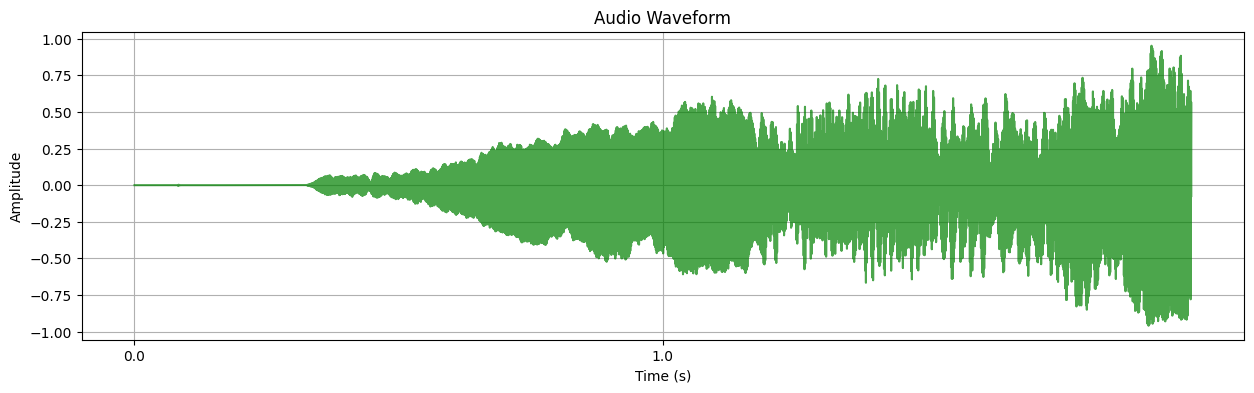

Epoch 0, Loss: 0.059598
Epoch 100, Loss: 0.000017
Epoch 200, Loss: 0.000000
Epoch 300, Loss: 0.000000
Epoch 400, Loss: 0.000000
Epoch 500, Loss: 0.000000
Epoch 600, Loss: 0.000000
Epoch 700, Loss: 0.000722
Epoch 800, Loss: 0.000000
Epoch 900, Loss: 0.000000
Epoch 1000, Loss: 0.000103
Epoch 1100, Loss: 0.000000
Epoch 1200, Loss: 0.000000
Epoch 1300, Loss: 0.000070
Epoch 1400, Loss: 0.000000
RMSE: 0.000334
SNR: 57.279770 dB


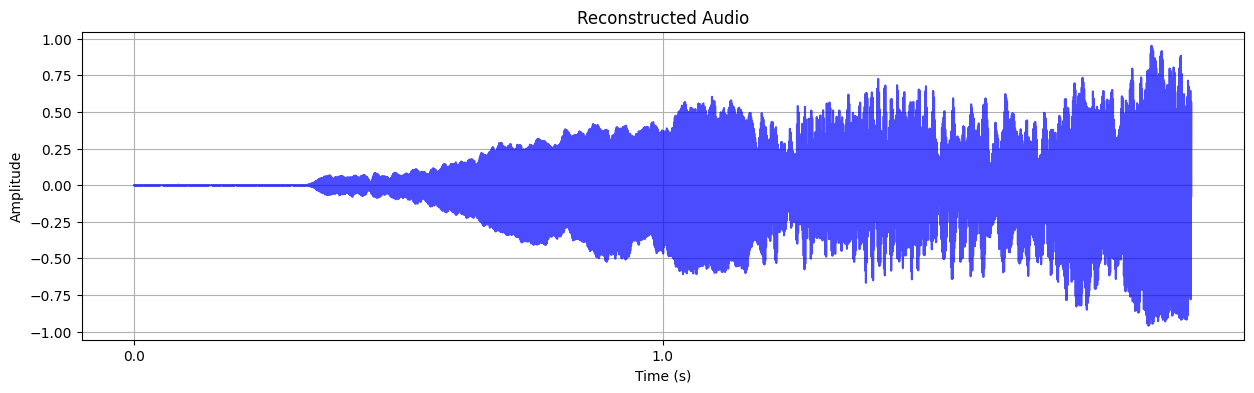

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error
from IPython.display import Audio

# Load and preprocess audio
waveform, sample_rate = torchaudio.load(r"C:\Users\chaud\OneDrive\Desktop\Audio\Radha Krishna Flute.mp3")
waveform = waveform.mean(0)  # Convert to mono
original_audio = waveform[:2 * sample_rate].numpy()  # Trim to first 2 seconds

# Plot original audio
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color=clr, alpha=0.7)
    plt.xticks(np.arange(0, len(audio), sr), np.arange(0, len(audio) / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

audio_plot(original_audio, sample_rate, "green", "Audio Waveform")

# Prepare data for RBF kernel transformation
X = torch.arange(0, len(original_audio)).unsqueeze(1).float()
X = X / X.max() * 300 - 150  # Scale to [-150, 150]

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma**2), random_state=42)
    X_np = X.cpu().numpy()
    X_transformed = rff.fit_transform(X_np)
    return torch.tensor(X_transformed, dtype=torch.float32)

# Create RFF features
num_features = 1000
sigma = 0.005
X_rff = create_rff_features(X, num_features, sigma)

# Define and train a simple model
class SimpleLinearModel(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleLinearModel, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, out_features)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleLinearModel(X_rff.shape[1], 1).to(X.device)

# Train the model
def train(model, X, Y, lr=0.001, epochs=1500):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

# Prepare labels (use original audio as target)
Y = torch.tensor(original_audio[:len(X_rff)], dtype=torch.float32).unsqueeze(1).to(X.device)

# Train the model
train(model, X_rff, Y, lr=0.001, epochs=1500)

# Reconstruct audio
def reconstruct_audio(model, X):
    model.eval()
    with torch.no_grad():
        reconstructed_audio = model(X).cpu().numpy()
    return reconstructed_audio.flatten()

# Perform reconstruction
reconstructed_audio = reconstruct_audio(model, X_rff)

# Calculate metrics
def calculate_metrics(original_signal, reconstructed_signal):
    original_signal = original_signal[:len(reconstructed_signal)]  # Adjust length if needed
    rmse = np.sqrt(mean_squared_error(original_signal, reconstructed_signal))
    snr = 10 * np.log10(np.sum(original_signal ** 2) / np.sum((original_signal - reconstructed_signal) ** 2))
    return rmse, snr

rmse, snr = calculate_metrics(original_audio, reconstructed_audio)
print(f"RMSE: {rmse:.6f}")
print(f"SNR: {snr:.6f} dB")

# Display the original and reconstructed audio
Audio(original_audio, rate=sample_rate)
Audio(reconstructed_audio, rate=sample_rate)

# Plot reconstructed audio
audio_plot(reconstructed_audio, sample_rate, "blue", "Reconstructed Audio")
